In [1]:
import sys
sys.path.append("./../..")

In [2]:
%load_ext autoreload
%autoreload 2

In [32]:

#
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
#
from effcn.models_mnist import CapsNet, CapsNetCross,EffCapsNetCross, EffCapsNet
from misc.utils import count_parameters, calc_receptive_field, layer_conv, bb_pc_vals, calc_layer_combs, rf_layer_combs
from misc.plot_utils import imshow, plot_mat

### Local Func

In [256]:
def show_imgrid(x,y=None,nrow=8):
    if y is not None:
        print(y.view(-1,nrow))

    img = torchvision.utils.make_grid(x[:64,:1,:,:], nrow=nrow)
    img = img.permute((1,2,0))
    plt.imshow(img)
    plt.show()


In [152]:
def show_pc_vals(pc, ncol=8, cmap="copper", figsize=(12,50)):
    """
    IN: mat -> torch.tensor(pc_no, pc_dim), Primecaps of one Input 
    """
    
    mat = pc.view(ncol, -1, pc.shape[1])
    mat = mat.cpu().detach().numpy()
    
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(1, mat.shape[0], sharex=False, sharey=True)

    for i in range(mat.shape[0]):
        ax[i].imshow(mat[i], cmap="copper")

    plt.show()

In [226]:
def calc_pc_delta(pc1, pc2):
    """
    generate norm over capsule dimension
    subtract values of 2 inputs elementwise
    generate norm over dims for scarlar output -> maybe some better way?

    IN: pc1, pc2 -> PrimeCaps of 2 inputs (pc_no, pc_dim)
    OUT: norm_delta -> calculated delta
    """
    pc1 = pc1.norm(dim=-1) 
    pc2 = pc2.norm(dim=-1)
    delta = pc1 - pc2
    norm_delta = delta.norm(dim=-1)
    return norm_delta

### Load Dataset

In [13]:
p_data = '/mnt/data/datasets'

In [14]:
ds = datasets.MNIST(root=p_data, train=False,download=False, transform=T.ToTensor())

In [15]:
bs = 32
shuffle=False
dl = torch.utils.data.DataLoader(ds,batch_size=bs,shuffle=shuffle)

In [16]:
x, y = next(iter(dl))

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


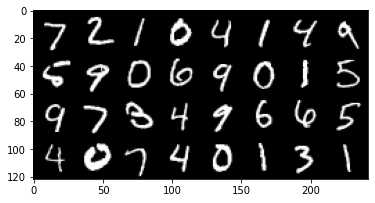

In [17]:
show_imgrid(x,y,nrow=8)

### Load Model

In [18]:
p_model = '/mnt/data/experiments/CN/mnist/mnist_CapsNet_2022_05_17_13_28_17/ckpts/model_150.ckpt'

In [19]:
CN = CapsNet()
CN.load_state_dict(torch.load(p_model))
CN.eval()

CapsNet(
  (backbone): BackboneHinton(
    (layers): Sequential(
      (0): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (primcaps): PrimaryCapsLayer(
    (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    (squash): SquashHinton()
  )
  (digitcaps): CapsLayer(
    (routing_module): AgreementRouting(
      (squash): SquashHinton()
    )
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [20]:
y_pred, x_reg = CN(x)

print(y_pred.shape, x_reg.shape)

torch.Size([32, 10, 16]) torch.Size([32, 1, 28, 28])


tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


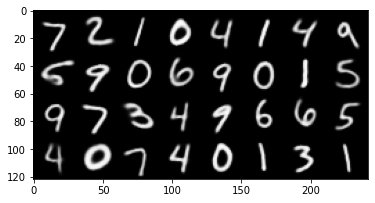

In [21]:
show_imgrid(x_reg,y,nrow=8)

In [22]:
u_h, x_rec, u_l, bb = CN.forward_pc_study(x)

print('Backbone Shape:       {}'.format(bb.shape))
print('PrimeCaps Shape:      {}'.format(u_l.shape))
print('ClassCaps Shape:      {}'.format(u_h.shape))
print('Reconstruction Shape: {}'.format(x_rec.shape))

Backbone Shape:       torch.Size([32, 256, 20, 20])
PrimeCaps Shape:      torch.Size([32, 1152, 8])
ClassCaps Shape:      torch.Size([32, 10, 16])
Reconstruction Shape: torch.Size([32, 1, 28, 28])


In [126]:
mat = u_l[0].cpu().detach().numpy()

u_l[0].shape, u_l[0].max(), u_l[0].min()

(torch.Size([1152, 8]),
 tensor(0.9995, grad_fn=<MaxBackward1>),
 tensor(-0.9987, grad_fn=<MinBackward1>))

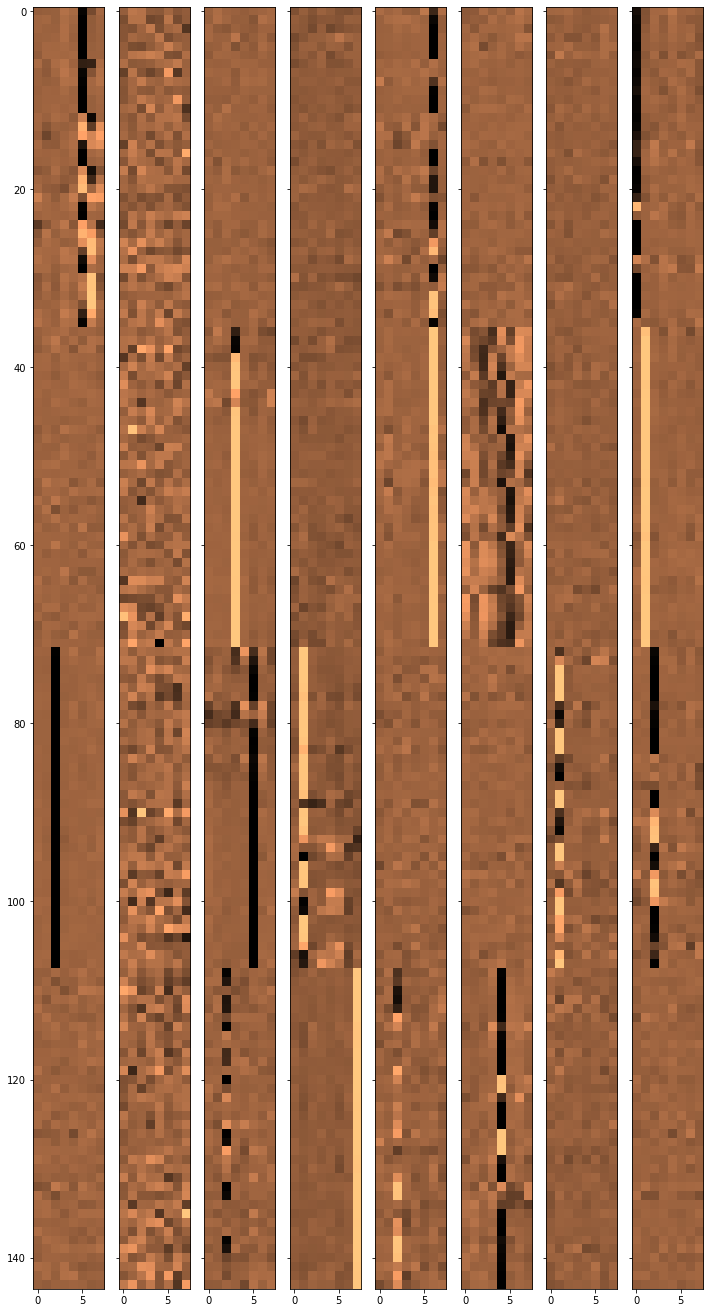

In [161]:
show_pc_vals(pc=u_l[7], ncol=8, cmap="copper", figsize=(12,50))

torch.Size([1152, 8])
tensor(0.9999, grad_fn=<MaxBackward1>) tensor(0.0075, grad_fn=<MinBackward1>) torch.Size([1152, 1])


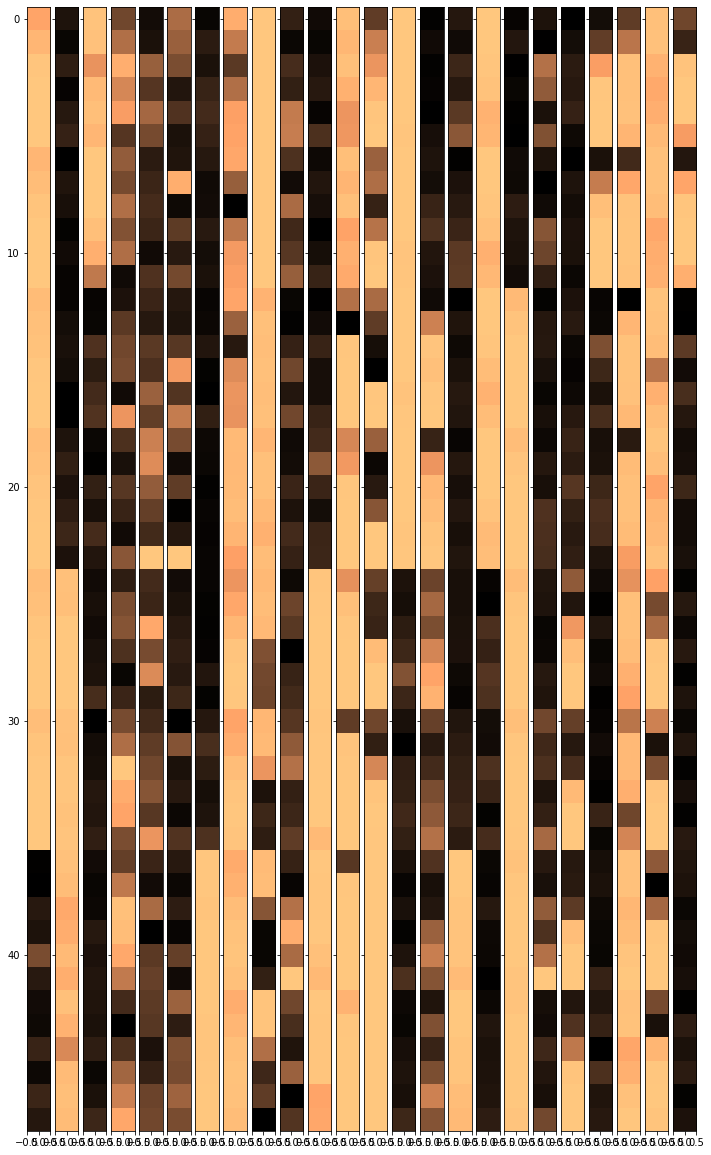

In [188]:
print(u_l[4].shape)

u_norm = u_l[5].norm(dim=1,keepdim=True)

print(u_norm.max(), u_norm.min(), u_norm.shape)

show_pc_vals(pc=u_norm , ncol=24, cmap="copper", figsize=(12,50))

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


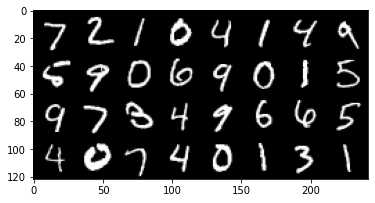

In [175]:
show_imgrid(x,y,nrow=8)

In [189]:
# test same numbers

# generate norm over capsule dimension
# subtract values of 2 inputs elementwise
# generate norm over dims for scarlar output -> maybe some better way?

n1 = u_l[4].norm(dim=1)
n2 = u_l[6].norm(dim=1)

print(n1.norm(), n2.norm())
print((n1-n2).norm())

n3 = u_l[0].norm(dim=1)

print(n1.norm(), n3.norm())
print((n1-n3).norm())

print((n3-n1).norm())
print((u_l[4]-u_l[0]).norm())



tensor(23.1063, grad_fn=<CopyBackwards>) tensor(22.5932, grad_fn=<CopyBackwards>)
tensor(5.0927, grad_fn=<CopyBackwards>)
tensor(23.1063, grad_fn=<CopyBackwards>) tensor(22.2777, grad_fn=<CopyBackwards>)
tensor(5.5425, grad_fn=<CopyBackwards>)
tensor(5.5425, grad_fn=<CopyBackwards>)
tensor(25.0638, grad_fn=<CopyBackwards>)


In [212]:
calc_pc_delta(pc1=u_l[4], pc2=u_l[6])

tensor(5.0927, grad_fn=<CopyBackwards>)

### Transform test

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


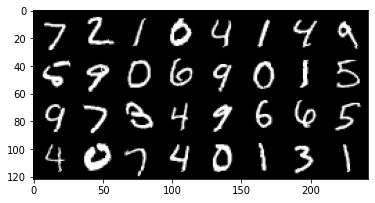

In [250]:
# https://pytorch.org/vision/stable/transforms.html
x_tf = TF.rotate(x, -3)

show_imgrid(x_tf,y,nrow=8)

torch.Size([32, 10, 16]) torch.Size([32, 1, 28, 28])
tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


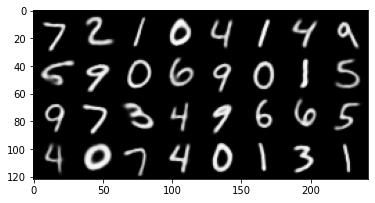

In [257]:
u_h_tf, x_rec_tf, u_l_tf, bb_tf = CN.forward_pc_study(x_tf)

print(y_tf_pred.shape,  x_rec_tf.shape)

show_imgrid( x_rec_tf,y,nrow=8)

In [252]:
idx = 6

calc_pc_delta(pc1=u_l[idx], pc2=u_l_tf[idx])

tensor(0.4593, grad_fn=<CopyBackwards>)

In [253]:
calc_pc_delta(pc1=u_l, pc2=u_l_tf)

tensor([0.9636, 1.2433, 1.0547, 0.4391, 0.5065, 0.6141, 0.4593, 0.5161, 0.3882,
        0.5970, 0.3296, 0.7509, 0.6944, 0.4484, 0.8651, 0.6285, 0.8894, 1.2345,
        0.4674, 0.4844, 0.7245, 1.1436, 0.5706, 0.4694, 0.4015, 0.4061, 0.9894,
        0.3755, 0.3434, 0.0000, 0.6027, 0.6311], grad_fn=<CopyBackwards>)

### random input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 28, 28])


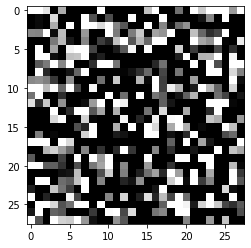

In [283]:
torch.manual_seed(42)

#x_rand = torch.randn(1,1,28,28)
x_rand = torch.randn(1,1,28,28)

print(x_rand.shape)

show_imgrid(x_rand,nrow=1)

In [284]:
u_h_rand, x_rec_rand, u_l_rand, bb_rand = CN.forward_pc_study(x_rand)

print(u_l_rand.shape)

torch.Size([1, 1152, 8])


In [285]:
calc_pc_delta(pc1=u_l, pc2=u_l_rand)

tensor([21.0075, 21.4612, 21.4905, 22.6873, 19.7020, 21.9162, 20.3397, 21.2197,
        19.0103, 22.6613, 20.7924, 21.3547, 22.1323, 21.3863, 20.7360, 18.3568,
        21.4771, 20.8400, 19.9203, 19.2415, 22.3708, 21.2898, 20.7390, 20.1130,
        21.0513, 22.9542, 20.9040, 19.9079, 21.8035, 20.3693, 19.6135, 20.5917],
       grad_fn=<CopyBackwards>)

In [286]:
u_norm = u_l[5].norm(dim=1,keepdim=True)

print(u_norm.max(), u_norm.min(), u_norm.shape)

#show_pc_vals(pc=u_norm , ncol=24, cmap="copper", figsize=(12,50))

tensor(0.9999, grad_fn=<MaxBackward1>) tensor(0.0075, grad_fn=<MinBackward1>) torch.Size([1152, 1])


torch.Size([1152, 1])


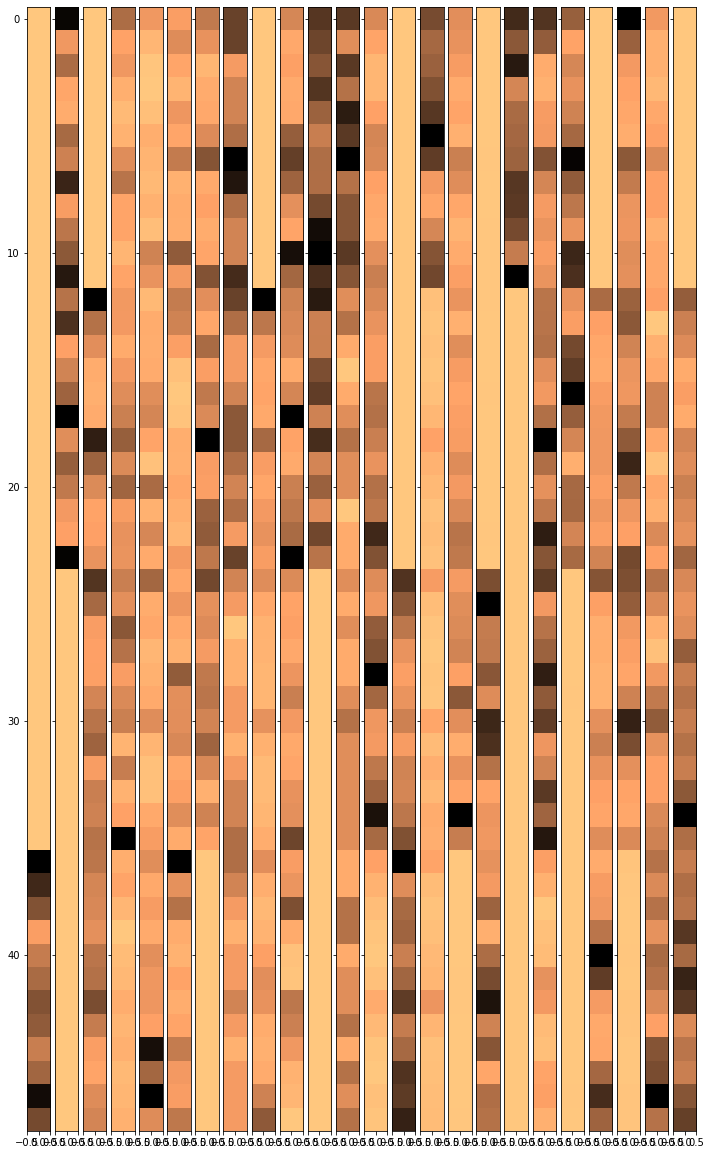

In [287]:
u_norm_rand = u_l_rand.norm(dim=-1,keepdim=True).squeeze(0)

print(u_norm_rand.shape)

show_pc_vals(pc=u_norm_rand , ncol=24, cmap="copper", figsize=(12,50))